In [1]:
# Import all required packages
import pandas as pd

In [2]:
# Import COVID data from github
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
covid = pd.read_csv(url, 
                    sep=',', 
                    compression=None, 
                    dtype={'fips':str},
                    parse_dates=['date'], 
                    cache_dates = True)

In [3]:
# View first 5 rows to check data loaded correctly
covid.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
3,2020-01-24,Cook,Illinois,17031,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0


In [4]:
covid[covid['fips']=='53061']

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0
7,2020-01-25,Snohomish,Washington,53061,1,0.0
...,...,...,...,...,...,...
1274138,2021-04-30,Snohomish,Washington,53061,35942,566.0
1277385,2021-05-01,Snohomish,Washington,53061,36093,566.0
1280632,2021-05-02,Snohomish,Washington,53061,36093,566.0
1283880,2021-05-03,Snohomish,Washington,53061,36303,568.0


In [5]:
# See minimum date to determine if need to use different Census population estimates
min(covid.date)

Timestamp('2020-01-21 00:00:00')

In [6]:
# Check data types and if there are Nulls
# Note there are NULLs in FIPS and deaths is set to float because it also has nulls
# Will need to fix this
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287285 entries, 0 to 1287284
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   date    1287285 non-null  datetime64[ns]
 1   county  1287285 non-null  object        
 2   state   1287285 non-null  object        
 3   fips    1275503 non-null  object        
 4   cases   1287285 non-null  int64         
 5   deaths  1258852 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 58.9+ MB


In [7]:
# Replace any NULLS in cases and deaths with 0 - does not appear to be documentation to suggest otherwise
int_cols = ['cases','deaths']
covid.fillna(value={col:0 for col in int_cols}, axis=0, inplace=True)
for col in int_cols:
    covid[col] = covid[col].astype(pd.Int64Dtype())
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287285 entries, 0 to 1287284
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   date    1287285 non-null  datetime64[ns]
 1   county  1287285 non-null  object        
 2   state   1287285 non-null  object        
 3   fips    1275503 non-null  object        
 4   cases   1287285 non-null  Int64         
 5   deaths  1287285 non-null  Int64         
dtypes: Int64(2), datetime64[ns](1), object(3)
memory usage: 61.4+ MB


In [8]:
# Investigate NULL FIPS values
covid['county,state'] = covid.county + ',' + covid.state
pd.unique(covid['county,state'][covid.fips.isna()])

array(['New York City,New York', 'Unknown,Rhode Island',
       'Unknown,New Jersey', 'Unknown,Puerto Rico',
       'Unknown,Virgin Islands', 'Unknown,Guam', 'Unknown,Maine',
       'Unknown,Massachusetts', 'Unknown,Louisiana', 'Unknown,Kentucky',
       'Unknown,Nevada', 'Unknown,Tennessee', 'Unknown,Arkansas',
       'Unknown,Georgia', 'Kansas City,Missouri', 'Unknown,Missouri',
       'Unknown,Minnesota', 'Unknown,California', 'Unknown,Colorado',
       'Unknown,Florida', 'Unknown,Hawaii', 'Unknown,Illinois',
       'Unknown,Vermont', 'Unknown,Arizona', 'Unknown,Michigan',
       'Unknown,Texas', 'Unknown,Virginia', 'Unknown,Washington',
       'Unknown,Utah', 'Unknown,Idaho', 'Unknown,Mississippi',
       'Unknown,Northern Mariana Islands', 'Unknown,New York',
       'Unknown,Connecticut', 'Unknown,Nebraska', 'Unknown,Montana',
       'Unknown,Pennsylvania', 'Unknown,Indiana', 'Unknown,Iowa',
       'Unknown,Maryland', 'Unknown,Oklahoma', 'Unknown,West Virginia',
       'Unknown,Al

In [9]:
# Unable to identify correct county for 'Unknown' county so will need to exclude from final data set- check what remains that isn't 'Unknown'
# Able to identify correct county for New York City, Kansas City, and Joplin so will want to include in the correct county in final result
pd.unique(covid['county,state'][(covid.fips.isna()) & (covid.county != 'Unknown')])

array(['New York City,New York', 'Kansas City,Missouri',
       'Joplin,Missouri'], dtype=object)

In [10]:
# Counties for each City with missing FIPS
missing_fips_county_dict = {'New York City,New York':['Bronx County','Kings County','New York County','Queens County', 'Richmond County'],
                              'Kansas City,Missouri':['Cass County', 'Clay County', 'Jackson County', 'Platte County'],
                               'Joplin,Missouri':['Jasper County','Newton County']}


In [11]:
# Import Census data from local file using relative path
filepath = '../data/co-est2019-alldata.csv'
census = pd.read_csv(filepath, sep = ',', compression=None)

In [12]:
# View first 5 rows to check data loaded correctly
census.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [13]:
#Get list of column names to identify the only columns needed for analysis so we only load the columns we need in to memory to speed up processing
census.columns.values

array(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME',
       'CTYNAME', 'CENSUS2010POP', 'ESTIMATESBASE2010', 'POPESTIMATE2010',
       'POPESTIMATE2011', 'POPESTIMATE2012', 'POPESTIMATE2013',
       'POPESTIMATE2014', 'POPESTIMATE2015', 'POPESTIMATE2016',
       'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019',
       'NPOPCHG_2010', 'NPOPCHG_2011', 'NPOPCHG_2012', 'NPOPCHG_2013',
       'NPOPCHG_2014', 'NPOPCHG_2015', 'NPOPCHG_2016', 'NPOPCHG_2017',
       'NPOPCHG_2018', 'NPOPCHG_2019', 'BIRTHS2010', 'BIRTHS2011',
       'BIRTHS2012', 'BIRTHS2013', 'BIRTHS2014', 'BIRTHS2015',
       'BIRTHS2016', 'BIRTHS2017', 'BIRTHS2018', 'BIRTHS2019',
       'DEATHS2010', 'DEATHS2011', 'DEATHS2012', 'DEATHS2013',
       'DEATHS2014', 'DEATHS2015', 'DEATHS2016', 'DEATHS2017',
       'DEATHS2018', 'DEATHS2019', 'NATURALINC2010', 'NATURALINC2011',
       'NATURALINC2012', 'NATURALINC2013', 'NATURALINC2014',
       'NATURALINC2015', 'NATURALINC2016', 'NATURALINC2017',
       'NAT

In [14]:
# Re-load file with just the desired columns
columns = ['STATE', 'COUNTY', 'STNAME',
       'CTYNAME', 'CENSUS2010POP', 'POPESTIMATE2019']
census = pd.read_csv(filepath, sep = ',', compression=None, usecols = columns )

In [15]:
# View first 5 rows to check data loaded correctly
census.head()

,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,POPESTIMATE2019
0,1,0,Alabama,Alabama,4779736,4903185
1,1,1,Alabama,Autauga County,54571,55869
2,1,3,Alabama,Baldwin County,182265,223234
3,1,5,Alabama,Barbour County,27457,24686
4,1,7,Alabama,Bibb County,22915,22394


In [16]:
# View data types and row counts
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATE            3193 non-null   int64 
 1   COUNTY           3193 non-null   int64 
 2   STNAME           3193 non-null   object
 3   CTYNAME          3193 non-null   object
 4   CENSUS2010POP    3193 non-null   int64 
 5   POPESTIMATE2019  3193 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 149.8+ KB


In [17]:
# Check FIPS code in COVID data compared to break-down in Census data
covid['fips'][(covid['county'] == 'Autauga') & (covid['state'] =='Alabama')].unique()

array(['01001'], dtype=object)

In [18]:
census[census['CTYNAME'] == 'Autauga County']

,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,POPESTIMATE2019
1,1,1,Alabama,Autauga County,54571,55869


In [19]:
# Create FIPS column in Census data = 2-digit State Code with zero padding + 3-digit County Code with zero padding
census['FIPS'] = census['STATE'].astype(str).str.zfill(2) + census['COUNTY'].astype(str).str.zfill(3)

In [20]:
census['FIPS'].head()

0    01000
1    01001
2    01003
3    01005
4    01007
Name: FIPS, dtype: object

In [21]:
# Sanity check same value for County/State in both datasets
covid['county,state'][covid['fips']=='49051'].unique()

array(['Wasatch,Utah'], dtype=object)

In [22]:
census[['STNAME','CTYNAME']][census['FIPS']=='49051']

,STNAME,CTYNAME
2847,Utah,Wasatch County


In [23]:
# Check what cities are listed in the census data set - not the ones we have a missing FIPS value for
census[census['CTYNAME'].str.contains('city', na=False)]

,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,POPESTIMATE2019,FIPS
1237,24,510,Maryland,Baltimore city,620961,593490,24510
1623,29,510,Missouri,St. Louis city,319294,300576,29510
2962,51,510,Virginia,Alexandria city,139966,159428,51510
2963,51,520,Virginia,Bristol city,17835,16762,51520
2964,51,530,Virginia,Buena Vista city,6650,6478,51530
2965,51,540,Virginia,Charlottesville city,43475,47266,51540
2966,51,550,Virginia,Chesapeake city,222209,244835,51550
2967,51,570,Virginia,Colonial Heights city,17411,17370,51570
2968,51,580,Virginia,Covington city,5961,5538,51580
2969,51,590,Virginia,Danville city,43055,40044,51590


In [24]:
# Create file from census data with state level fips codes. 
# This will allow us to replace the Unknown County data with FIPS codes at the state level.
# This will allow us to not lose this data when doing full aggregation across all states and gives easy access to the state population
# Carefully document this in the README

state_level_data = census.loc[census['COUNTY'] == 0,['STNAME','FIPS']]
state_level_data.to_csv('..\data\state_level_fips_codes.csv', sep='|',header=True, index=False)
state_level_data

,STNAME,FIPS
0,Alabama,01000
68,Alaska,02000
98,Arizona,04000
114,Arkansas,05000
190,California,06000
249,Colorado,08000
314,Connecticut,09000
323,Delaware,10000
327,District of Columbia,11000
329,Florida,12000


In [25]:
# Merge the State Level Data with the Covid data to apply the state level FIPS code to the Unknown Counties
covid = covid.merge(state_level_data, how='left', left_on='state', right_on='STNAME')
covid.loc[covid['county']=='Unknown','fips'] = covid.loc[covid['county']=='Unknown','FIPS']
covid.drop(columns=['STNAME','FIPS'], inplace=True)
covid

,date,county,state,fips,cases,deaths,"county,state"
0,2020-01-21,Snohomish,Washington,53061,1,0,"Snohomish,Washington"
1,2020-01-22,Snohomish,Washington,53061,1,0,"Snohomish,Washington"
2,2020-01-23,Snohomish,Washington,53061,1,0,"Snohomish,Washington"
3,2020-01-24,Cook,Illinois,17031,1,0,"Cook,Illinois"
4,2020-01-24,Snohomish,Washington,53061,1,0,"Snohomish,Washington"
...,...,...,...,...,...,...,...
1287280,2021-05-04,Sweetwater,Wyoming,56037,4254,38,"Sweetwater,Wyoming"
1287281,2021-05-04,Teton,Wyoming,56039,3741,9,"Teton,Wyoming"
1287282,2021-05-04,Uinta,Wyoming,56041,2204,13,"Uinta,Wyoming"
1287283,2021-05-04,Washakie,Wyoming,56043,905,26,"Washakie,Wyoming"


In [26]:
# Investigate still NULL FIPS values
covid['county,state'] = covid.county + ',' + covid.state
pd.unique(covid['county,state'][covid.fips.isna()])

array(['New York City,New York', 'Unknown,Puerto Rico',
       'Unknown,Virgin Islands', 'Unknown,Guam', 'Kansas City,Missouri',
       'Unknown,Northern Mariana Islands', 'Joplin,Missouri'],
      dtype=object)

In [27]:
# Calculate relative population size of counties for the covid entries with missing fips codes
# Break the data for the cities in to the respective counties proportionaly based on the relative size of the counties
# This is still inaccurate but at least does not eliminate the data from these large cities when looking at fips level data

population_data = []
for citystate, counties in missing_fips_county_dict.items():
    state = citystate.split(',')[1] # State is after the comma in the dictionary key
    for county in counties:
        population, fips = census.loc[(census['STNAME']==state) & (census['CTYNAME'] ==county), ['POPESTIMATE2019','FIPS']].iloc[0,:]
        population_data.append([citystate, county, state, population, fips])

population_df = pd.DataFrame(population_data, columns=['City,State','County','State','Population', 'FIPS'])    
population_df['Total City,State Population'] = population_df.groupby(['City,State'])['Population'].transform('sum') 
population_df['County Population Proportion'] = round(population_df.loc[:,'Population']/population_df.loc[:,'Total City,State Population'],2)

# Write data frame to file so that it can be used in ETL process. This will be static as long as the census data is static.
# Pipe delimited file because column name includes a 'comma'
population_df.to_csv('../data/missing_fips_population_proportion.csv', sep='|', header=True, index=False)
population_df

,"City,State",County,State,Population,FIPS,"Total City,State Population",County Population Proportion
0,"New York City,New York",Bronx County,New York,1418207,36005,8336817,0.17
1,"New York City,New York",Kings County,New York,2559903,36047,8336817,0.31
2,"New York City,New York",New York County,New York,1628706,36061,8336817,0.20
3,"New York City,New York",Queens County,New York,2253858,36081,8336817,0.27
4,"New York City,New York",Richmond County,New York,476143,36085,8336817,0.06
5,"Kansas City,Missouri",Cass County,Missouri,105780,29037,1163157,0.09
6,"Kansas City,Missouri",Clay County,Missouri,249948,29047,1163157,0.21
7,"Kansas City,Missouri",Jackson County,Missouri,703011,29095,1163157,0.60
8,"Kansas City,Missouri",Platte County,Missouri,104418,29165,1163157,0.09
9,"Joplin,Missouri",Jasper County,Missouri,121328,29097,179564,0.68


In [28]:
# Merge population proportions to main dataframe on FIPS to attach population proportion amounts to Missouri Counties that are part of a city reported separately
# New York City will have to be handled separately later
covid = covid.merge(population_df[['City,State','FIPS','County Population Proportion']], how='left', left_on='fips', right_on='FIPS')

# Merge covid dataframe to itself on City,State/count,state and date to add the cases and deaths for the cities reported separately from the counties and result in no fips
covid = covid.merge(covid[['date','county,state','cases','deaths']], how='left', left_on=['City,State','date'],right_on=['county,state','date'], suffixes=[None,'_city'])

# Add the city cases and deaths to the county cases and deaths based on the relative size of the counties, round down to insure integer number of cases
filter_condition = ~covid['cases_city'].isna()
covid.loc[filter_condition,'cases'] += (covid.loc[filter_condition,'County Population Proportion']*covid.loc[filter_condition,'cases_city']).astype(int)
covid.loc[filter_condition,'deaths'] += (covid.loc[filter_condition,'County Population Proportion']*covid.loc[filter_condition,'deaths_city']).astype(int)

# Remove columns only added for calculations
covid.drop(labels=['City,State','FIPS','County Population Proportion', 'county,state_city', 'cases_city', 'deaths_city'], axis = 1, inplace=True)
covid[filter_condition]

,date,county,state,fips,cases,deaths,"county,state"
5634,2020-03-20,Cass,Missouri,29037,7,0,"Cass,Missouri"
5640,2020-03-20,Jackson,Missouri,29095,12,1,"Jackson,Missouri"
6622,2020-03-21,Cass,Missouri,29037,7,0,"Cass,Missouri"
6628,2020-03-21,Jackson,Missouri,29095,12,1,"Jackson,Missouri"
7711,2020-03-22,Cass,Missouri,29037,7,0,"Cass,Missouri"
...,...,...,...,...,...,...,...
1285557,2021-05-04,Clay,Missouri,29047,19380,284,"Clay,Missouri"
1285581,2021-05-04,Jackson,Missouri,29095,63865,765,"Jackson,Missouri"
1285582,2021-05-04,Jasper,Missouri,29097,13494,199,"Jasper,Missouri"
1285608,2021-05-04,Newton,Missouri,29145,7200,110,"Newton,Missouri"


In [29]:
# Confirm no rows added during manipulation - should match the row count for the initial data read
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287285 entries, 0 to 1287284
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date          1287285 non-null  datetime64[ns]
 1   county        1287285 non-null  object        
 2   state         1287285 non-null  object        
 3   fips          1285015 non-null  object        
 4   cases         1287285 non-null  Int64         
 5   deaths        1287285 non-null  Int64         
 6   county,state  1287285 non-null  object        
dtypes: Int64(2), datetime64[ns](1), object(4)
memory usage: 81.0+ MB


In [30]:
# There should now be more columns because we have added five columns for every New York City entry
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287285 entries, 0 to 1287284
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date          1287285 non-null  datetime64[ns]
 1   county        1287285 non-null  object        
 2   state         1287285 non-null  object        
 3   fips          1285015 non-null  object        
 4   cases         1287285 non-null  Int64         
 5   deaths        1287285 non-null  Int64         
 6   county,state  1287285 non-null  object        
dtypes: Int64(2), datetime64[ns](1), object(4)
memory usage: 81.0+ MB


In [31]:
# Cases and deaths are reported as cumulative totals
# We must take the difference from the previous days record for each FIPS code to get daily totals
# First rename columns to be cumulative columns
covid.rename(columns={'cases':'cumulative cases to date', 'deaths':'cumulative deaths to date'},inplace=True)

In [32]:
# # Order data by fips and date ascending and reset the index to insure previous date logic will work
# covid.sort_values(by=['fips','date'],inplace=True, ascending = True)
# covid.reset_index(inplace=True)

In [33]:
def previous_row_value(df,shift_column,sort_column,groupby_column=None, fill_value=pd.NA ):
    """
    Parameters
    ----------
    df:
      Dataframe with a specific column to generate previous rows data
    shift_column:
      Stirng with specific column name to return the previous rows data
    sort_column:
      String with specific column name to sort the data by to insure expected previous rows data returned
    groupby_column:
      Optional string used to shift the data based on specific groups. The df will also be sorted by this column if it is passed to function.
    fill_vale:
      Option value used to fill the first row. Defaults to pandas "NA" if not passed to function.
    
    
    Returns
   -------
    df_with_shift:
        The original dataframe with a new column
        `previous_[shift_column]` containing the previous rows data
        based on the sort_column and optional groupby_column
    """
     
    if groupby_column is None:
        df.sort_values(by=[sort_column], inplace=True, ascending = True)
        df_with_shift = df.reset_index(drop=True)
        df_with_shift[f'previous {shift_column}'] = df_with_shift[shift_column].shift(1, fill_value=fill_value)
        return df_with_shift
    
    df.sort_values(by=[groupby_column,sort_column], inplace=True, ascending = True)
    df_with_shift = df.reset_index(drop=True)
    df_with_shift[f'previous {shift_column}'] = df_with_shift.groupby(groupby_column)[shift_column].shift(1, fill_value=fill_value)
    return df_with_shift

In [34]:
# Apply function to get the previous days cumulative cases and deaths for each each fips with a default value of 0 if no previous value
covid = previous_row_value(covid, shift_column='cumulative cases to date', sort_column='date', groupby_column='fips', fill_value=0)
covid = previous_row_value(covid, shift_column='cumulative deaths to date', sort_column='date', groupby_column='fips', fill_value=0)

In [35]:
# Calculate daily cases and deaths as todays cumulative total - yesterdays cumulative total
covid.loc[:,'daily cases'] = covid.loc[:,'cumulative cases to date'] - covid.loc[:,'previous cumulative cases to date']
covid.loc[:,'daily deaths'] = covid.loc[:,'cumulative deaths to date'] - covid.loc[:,'previous cumulative deaths to date']

# Drop previous columns and no longer needed county,state column
covid.drop(columns=['previous cumulative cases to date', 'previous cumulative deaths to date', 'county,state'], inplace=True)

# Known inconsistency in data that cumulative totals do not always increase if data is updated on a previous date.
# Leave negative values in data for now and clearly explain in README
# Consider data strategy in future to accomodate for this in a different way

In [36]:
covid

,date,county,state,fips,cumulative cases to date,cumulative deaths to date,daily cases,daily deaths
0,2020-03-24,Autauga,Alabama,01001,1,0,1,0
1,2020-03-25,Autauga,Alabama,01001,4,0,3,0
2,2020-03-26,Autauga,Alabama,01001,6,0,2,0
3,2020-03-27,Autauga,Alabama,01001,6,0,0,0
4,2020-03-28,Autauga,Alabama,01001,6,0,0,0
...,...,...,...,...,...,...,...,...
1287280,2021-05-04,Unknown,Guam,NaN,8973,138,<NA>,<NA>
1287281,2021-05-04,Joplin,Missouri,NaN,6019,106,<NA>,<NA>
1287282,2021-05-04,Kansas City,Missouri,NaN,43517,575,<NA>,<NA>
1287283,2021-05-04,New York City,New York,NaN,932181,32698,<NA>,<NA>


In [37]:
census

,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,POPESTIMATE2019,FIPS
0,1,0,Alabama,Alabama,4779736,4903185,01000
1,1,1,Alabama,Autauga County,54571,55869,01001
2,1,3,Alabama,Baldwin County,182265,223234,01003
3,1,5,Alabama,Barbour County,27457,24686,01005
4,1,7,Alabama,Bibb County,22915,22394,01007
...,...,...,...,...,...,...,...
3188,56,37,Wyoming,Sweetwater County,43806,42343,56037
3189,56,39,Wyoming,Teton County,21294,23464,56039
3190,56,41,Wyoming,Uinta County,21118,20226,56041
3191,56,43,Wyoming,Washakie County,8533,7805,56043


In [38]:
# Investigate any remaining NULL FIPS values
covid['county,state'] = covid.county + ',' + covid.state
pd.unique(covid['county,state'][covid.fips.isna()])

array(['New York City,New York', 'Unknown,Puerto Rico',
       'Unknown,Virgin Islands', 'Unknown,Guam', 'Kansas City,Missouri',
       'Unknown,Northern Mariana Islands', 'Joplin,Missouri'],
      dtype=object)

In [39]:
# Census data does not exist for US Territories so drop from dataset and Kansas City and Joplin data added in to apporiate county
# Okay to use INNER JOIN on merge to census data and drop these rows
# Check how many rows should remain after missing fips rows are dropped
covid['county,state'][~covid.fips.isna()].count()

1285015

In [40]:
# Finally we are able to merge the covid data with the census data to enhance the data with population data.
# Include actual 2010 census population data and Porjected 2019 Census population data

output = covid.merge(census, how='left', left_on='fips', right_on='FIPS')
output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287285 entries, 0 to 1287284
Data columns (total 16 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   date                       1287285 non-null  datetime64[ns]
 1   county                     1287285 non-null  object        
 2   state                      1287285 non-null  object        
 3   fips                       1285015 non-null  object        
 4   cumulative cases to date   1287285 non-null  Int64         
 5   cumulative deaths to date  1287285 non-null  Int64         
 6   daily cases                1285015 non-null  Int64         
 7   daily deaths               1285015 non-null  Int64         
 8   county,state               1287285 non-null  object        
 9   STATE                      1254175 non-null  float64       
 10  COUNTY                     1254175 non-null  float64       
 11  STNAME                     1254175 no

In [41]:
# Investigate data that didn't match
# Puerto Rico, Mariana Islands and Virgin Islands is expected because not in census data
# Need to investigate Alaska further
pd.unique(output['county,state'][((output['STATE'].isna()) & (output['county']!='Unknown') & (output['county']!='Kansas City')  & (output['county']!='Joplin'))])

array(['Bristol Bay plus Lake and Peninsula,Alaska',
       'Yakutat plus Hoonah-Angoon,Alaska',
       'Saipan,Northern Mariana Islands',
       'Tinian,Northern Mariana Islands', 'Adjuntas,Puerto Rico',
       'Aguada,Puerto Rico', 'Aguadilla,Puerto Rico',
       'Aguas Buenas,Puerto Rico', 'Aibonito,Puerto Rico',
       'Anasco,Puerto Rico', 'Arecibo,Puerto Rico', 'Arroyo,Puerto Rico',
       'Barceloneta,Puerto Rico', 'Barranquitas,Puerto Rico',
       'Bayamon,Puerto Rico', 'Cabo Rojo,Puerto Rico',
       'Caguas,Puerto Rico', 'Camuy,Puerto Rico', 'Canovanas,Puerto Rico',
       'Carolina,Puerto Rico', 'Catano,Puerto Rico', 'Cayey,Puerto Rico',
       'Ceiba,Puerto Rico', 'Ciales,Puerto Rico', 'Cidra,Puerto Rico',
       'Coamo,Puerto Rico', 'Comerio,Puerto Rico', 'Corozal,Puerto Rico',
       'Culebra,Puerto Rico', 'Dorado,Puerto Rico', 'Fajardo,Puerto Rico',
       'Florida,Puerto Rico', 'Guanica,Puerto Rico',
       'Guayama,Puerto Rico', 'Guayanilla,Puerto Rico',
       'Guayn

In [42]:
# Investigate Alaska in census data
census[census['STNAME']=='Alaska']

,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,POPESTIMATE2019,FIPS
68,2,0,Alaska,Alaska,710231,731545,02000
69,2,13,Alaska,Aleutians East Borough,3141,3337,02013
70,2,16,Alaska,Aleutians West Census Area,5561,5634,02016
71,2,20,Alaska,Anchorage Municipality,291826,288000,02020
72,2,50,Alaska,Bethel Census Area,17013,18386,02050
73,2,60,Alaska,Bristol Bay Borough,997,836,02060
74,2,68,Alaska,Denali Borough,1826,2097,02068
75,2,70,Alaska,Dillingham Census Area,4847,4916,02070
76,2,90,Alaska,Fairbanks North Star Borough,97581,96849,02090
77,2,100,Alaska,Haines Borough,2508,2530,02100


In [43]:
# Investigate FIPS value for
population_df = pd.read_csv('../data/missing_fips_population_proportion.csv', sep='|', dtype={'FIPS':str})

In [44]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   City,State                    11 non-null     object 
 1   County                        11 non-null     object 
 2   State                         11 non-null     object 
 3   Population                    11 non-null     int64  
 4   FIPS                          11 non-null     object 
 5   Total City,State Population   11 non-null     int64  
 6   County Population Proportion  11 non-null     float64
dtypes: float64(1), int64(2), object(4)
memory usage: 744.0+ bytes


In [45]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287285 entries, 0 to 1287284
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   date                       1287285 non-null  datetime64[ns]
 1   county                     1287285 non-null  object        
 2   state                      1287285 non-null  object        
 3   fips                       1285015 non-null  object        
 4   cumulative cases to date   1287285 non-null  Int64         
 5   cumulative deaths to date  1287285 non-null  Int64         
 6   daily cases                1285015 non-null  Int64         
 7   daily deaths               1285015 non-null  Int64         
 8   county,state               1287285 non-null  object        
dtypes: Int64(4), datetime64[ns](1), object(4)
memory usage: 93.3+ MB


In [103]:
# Unique Function Testing

def unique_test(data,columns):
    # Get total rows
    total_rows = len(data.index)
    
    # If input is a list, need to create column that is concatenaton of list values
    if type(columns) == list:
        new_column = '-'.join(columns)
        columns_new = [f"data.loc[:,'{col}'].astype('str')" for col in columns]
        data.loc[:,new_column] = eval((" + '-' + ").join(columns_new))
    else:
        new_column = columns
        
    # Get count of unique values in the unique tests column(s)
    distinct_rows = len(data[new_column].unique())
    
    #Retrun True/False if 
    return total_rows == distinct


In [107]:
unique_test(output,['date','fips'])

True

In [111]:
from datetime import datetime,timedelta

In [133]:
# Freshness Test Function Testsing
def test_date():
    # Test the most recent date is w/in 48 hours
    # Data should be updated daily on NY Times and Locally after run
    # Data should not be more than 48 hours old
    file_path = '../latest_covid19data_withpopulationdata.csv'
    input_data = pd.read_csv(file_path, sep=',')
    today = datetime.now()
    minimum_date = input_data['Date'].max()
    minimum_date = datetime.strptime(minimum_date, '%Y-%m-%d')
    return minimum_date >= today - timedelta(days=2)

In [134]:
test_date()

True

In [135]:
## Quick Sanity Check Graphs of data
df = pd.read_csv('../latest_covid19data_withpopulationdata.csv',sep=',')

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246813 entries, 0 to 1246812
Data columns (total 10 columns):
 #   Column                         Non-Null Count    Dtype 
---  ------                         --------------    ----- 
 0   Date                           1246813 non-null  object
 1   County                         1246813 non-null  object
 2   State                          1246813 non-null  object
 3   Cumulative Cases to Date       1246813 non-null  int64 
 4   Cumulative Deaths to Date      1246813 non-null  int64 
 5   Daily Cases                    1246813 non-null  int64 
 6   Daily Deaths                   1246813 non-null  int64 
 7   2010 Census Actual Population  1246813 non-null  int64 
 8   Estimated 2019 Population      1246813 non-null  int64 
 9   FIPS                           1246813 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 95.1+ MB


In [138]:
# Check how many entries per Stae. Expect largest states to have the most entries because likely the most counties
df.State.value_counts()

Texas                   98497
Georgia                 64639
Virginia                53347
Kentucky                47650
Missouri                45079
Illinois                40687
North Carolina          40408
Kansas                  39778
Iowa                    39301
Tennessee               38478
Indiana                 37473
Ohio                    35750
Minnesota               34566
Nebraska                33954
Mississippi             33411
Michigan                33382
Oklahoma                30485
Arkansas                30197
Wisconsin               28930
Florida                 27532
Pennsylvania            27381
Alabama                 27254
Louisiana               26180
New York                25710
Colorado                25527
South Dakota            24863
California              23984
West Virginia           21664
North Dakota            19960
Montana                 19710
South Carolina          18884
Idaho                   16716
Washington              16127
Oregon    

In [153]:
import matplotlib
# convert the 'Date' column to datetime format
df['Date']= pd.to_datetime(df['Date'])

<AxesSubplot:title={'center':'Total US Cases per Day'}, xlabel='Date'>

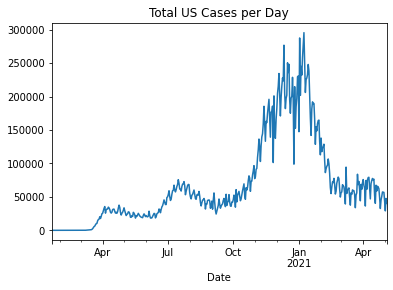

In [156]:
# Total cases per day plot
df.groupby('Date')['Daily Cases'].sum().plot(
    title = 'Total US Cases per Day',
    )

<AxesSubplot:title={'center':'Cumulative Cases in the US over Time'}, xlabel='Date'>

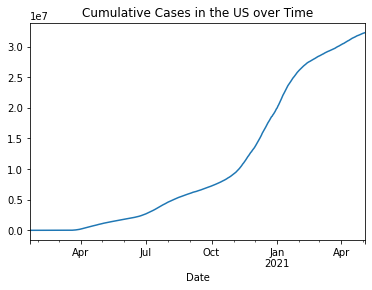

In [158]:
# Overall number of cases plot
df.groupby('Date')['Cumulative Cases to Date'].sum().plot(
    title = 'Cumulative Cases in the US over Time')